In [ ]:
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df1 = pd.read_csv('nba_2017_players_with_salary_wiki_twitter.csv')
df1.info()
df1.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              239 non-null    int64  
 1   Rk                      239 non-null    int64  
 2   PLAYER                  239 non-null    object 
 3   POSITION                239 non-null    object 
 4   AGE                     239 non-null    int64  
 5   MP                      239 non-null    float64
 6   FG                      239 non-null    float64
 7   FGA                     239 non-null    float64
 8   FG%                     239 non-null    float64
 9   3P                      239 non-null    float64
 10  3PA                     239 non-null    float64
 11  3P%                     232 non-null    float64
 12  2P                      239 non-null    float64
 13  2PA                     239 non-null    float64
 14  2P%                     239 non-null    fl

(239, 42)

In [ ]:
df1.isna()
df1 = df1.dropna()
categorical_vars = ['POSITION']

# Perform one-hot encoding
df1_encoded = pd.get_dummies(df1, columns=categorical_vars)

#Try dropping PIE_Rank since it is directly highly correlated with PIE and hence skews the feature importance of the model and it's results.

features1 = df1_encoded.drop(columns = ['PLAYER','PIE','TEAM'])
target1 = df1_encoded['PIE']

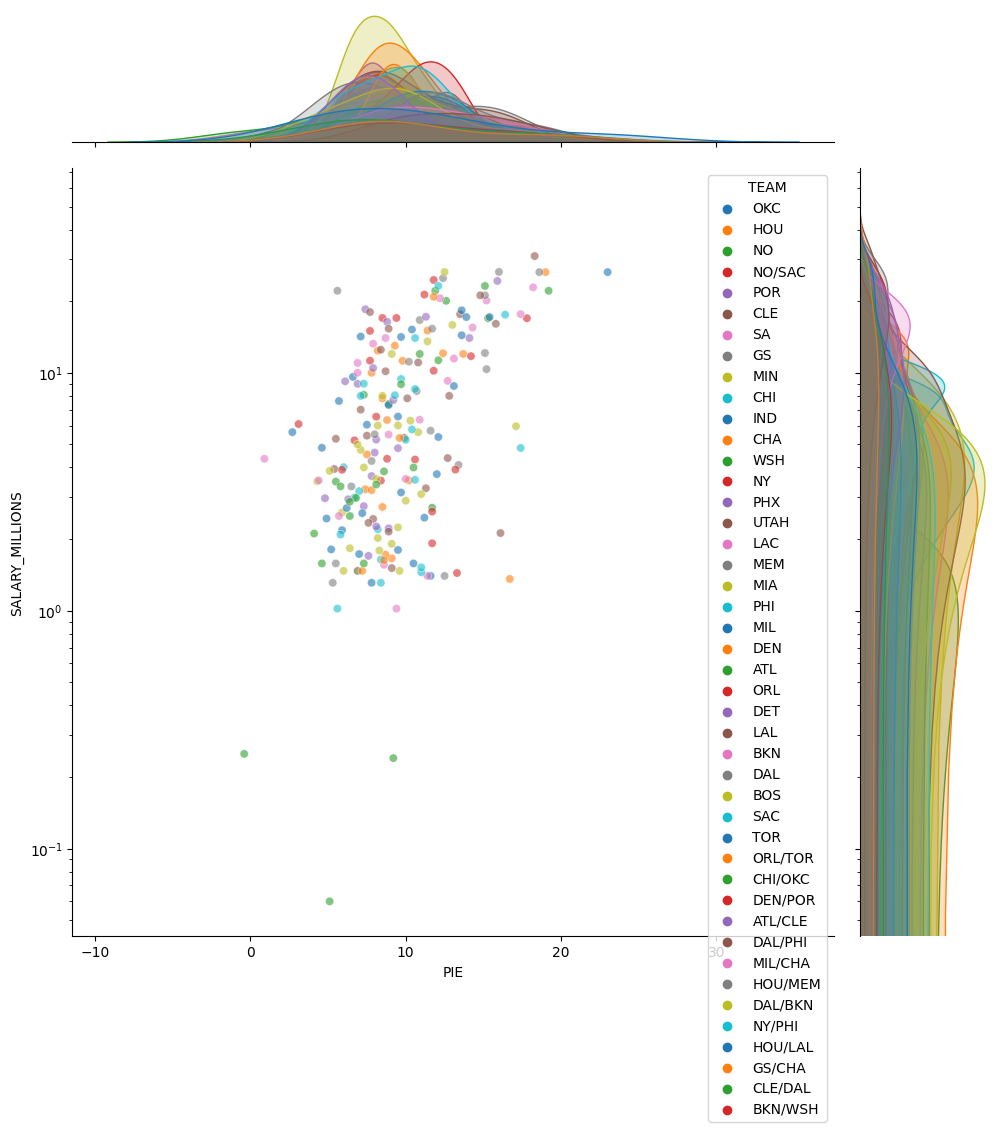

In [ ]:

sns.jointplot(data=df1.reset_index(), y='SALARY_MILLIONS',
              x='PIE', hue='TEAM', height=10, palette='tab10',
              alpha=0.6)
plt.yscale('log')

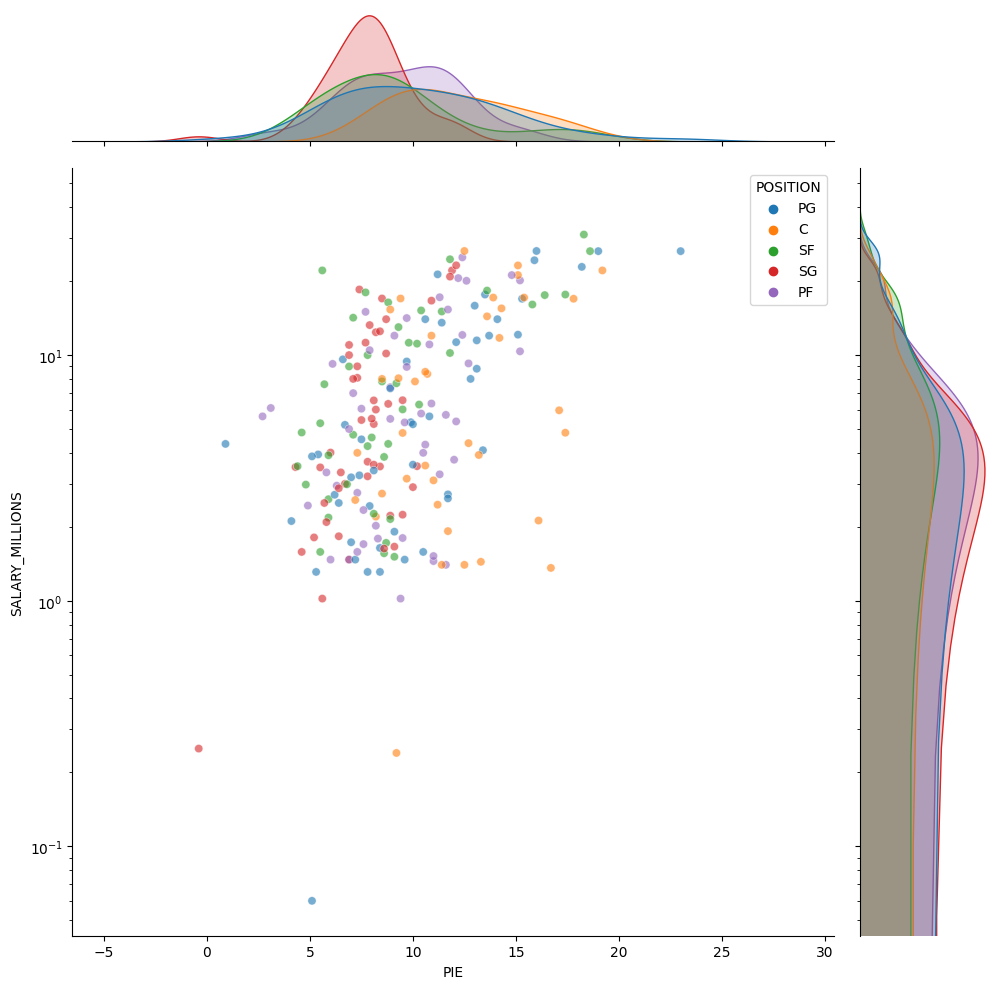

In [ ]:

sns.jointplot(data=df1.reset_index(), y='SALARY_MILLIONS',
              x='PIE', hue='POSITION', height=10, palette='tab10',
              alpha=0.6)
plt.yscale('log')

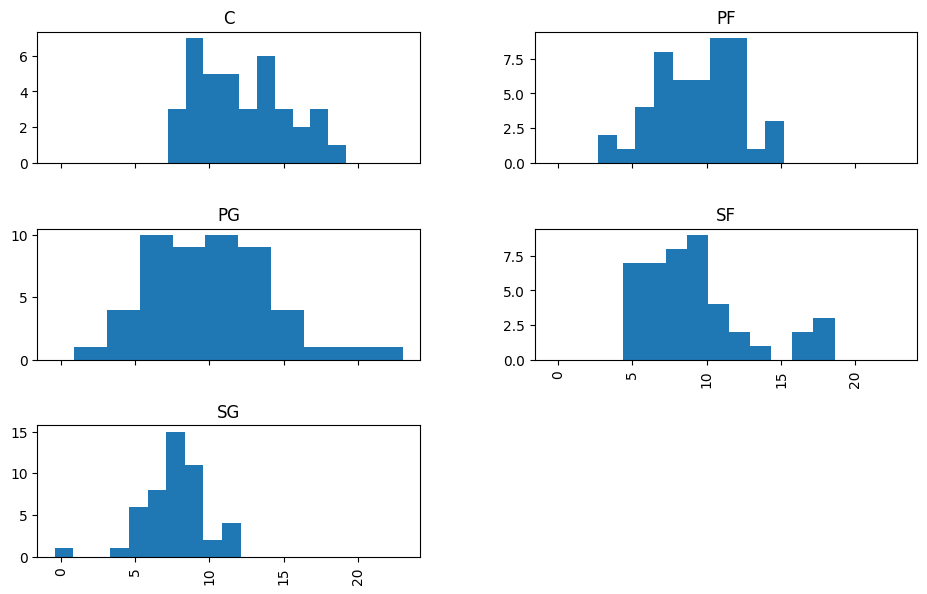

In [ ]:
df1[['POSITION', 'PIE']]\
    .reset_index(drop=True)\
    .hist(by='POSITION',figsize=(11,7), sharex=True)
plt.show()

In [ ]:
df1.pivot_table(
    values='SALARY_MILLIONS',
    index='PIE',
    columns='POSITION',
    aggfunc='count')\
        .style.background_gradient(cmap='Blues',axis=None)

POSITION,C,PF,PG,SF,SG
PIE,,,,,
-0.400000,nan,nan,nan,nan,1.000000
0.900000,nan,nan,1.000000,nan,nan
2.700000,nan,1.000000,nan,nan,nan
3.100000,nan,1.000000,nan,nan,nan
4.100000,nan,nan,1.000000,nan,nan
4.300000,nan,nan,nan,nan,1.000000
4.400000,nan,nan,nan,1.000000,nan
4.600000,nan,nan,nan,1.000000,1.000000
4.800000,nan,nan,nan,1.000000,nan


In [ ]:
df1.corr()\
    .style.background_gradient(
        cmap='RdBu',
        axis=None)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,Unnamed: 0,Rk,AGE,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,POINTS,GP,MPG,ORPM,DRPM,RPM,WINS_RPM,PIE,PACE,W,SALARY_MILLIONS,PAGEVIEWS,TWITTER_FAVORITE_COUNT,TWITTER_RETWEET_COUNT
Unnamed: 0,1.000000,0.991438,-0.012839,-0.911925,-0.952873,-0.948703,-0.280821,-0.620228,-0.614926,-0.317793,-0.864207,-0.871885,-0.175156,-0.341163,-0.800598,-0.801129,-0.389552,-0.307380,-0.627428,-0.562802,-0.614058,-0.622688,-0.335100,-0.756881,-0.523021,-0.947349,-0.505477,-0.911903,-0.749183,0.058988,-0.588607,-0.676684,-0.713156,-0.206200,-0.416610,-0.608887,-0.338306,-0.284676,-0.293711
Rk,0.991438,1.000000,-0.017074,-0.913904,-0.918728,-0.914290,-0.295994,-0.602651,-0.596721,-0.319555,-0.831380,-0.837982,-0.185712,-0.367469,-0.748232,-0.752440,-0.378711,-0.318829,-0.622052,-0.562364,-0.585993,-0.620855,-0.337758,-0.723217,-0.540328,-0.907949,-0.546397,-0.913891,-0.717834,0.059828,-0.561994,-0.643694,-0.686039,-0.209265,-0.439427,-0.583208,-0.302492,-0.252320,-0.263426
AGE,-0.012839,-0.017074,1.000000,0.046312,-0.007277,-0.011415,0.082301,0.078949,0.049691,0.033686,-0.043977,-0.042298,0.078544,0.156167,-0.014416,-0.026079,0.096114,-0.037813,0.061951,0.034369,0.096369,0.041847,-0.078522,-0.003376,-0.072233,0.001315,-0.043894,0.046475,0.138527,0.132719,0.194887,0.120342,0.104131,-0.056040,0.085747,0.355661,0.174408,0.051134,0.011139
MP,-0.911925,-0.913904,0.046312,1.000000,0.861700,0.866985,0.228444,0.582159,0.586852,0.286852,0.773465,0.783115,0.156591,0.299235,0.702325,0.711448,0.272756,0.314468,0.632268,0.568926,0.627019,0.720279,0.346446,0.707488,0.583052,0.854596,0.563815,1.000000,0.665474,0.041884,0.579326,0.692817,0.548778,0.161497,0.463174,0.583980,0.300817,0.213129,0.213462
FG,-0.952873,-0.918728,-0.007277,0.861700,1.000000,0.977721,0.316784,0.571904,0.566408,0.264633,0.939579,0.935794,0.208646,0.327575,0.846190,0.848339,0.329631,0.338325,0.649770,0.589788,0.618325,0.591475,0.361284,0.786176,0.489720,0.986053,0.456846,0.861662,0.758720,-0.038861,0.608608,0.716185,0.764713,0.185890,0.397974,0.642296,0.433294,0.347070,0.350849
FGA,-0.948703,-0.914290,-0.011415,0.866985,0.977721,1.000000,0.141475,0.655070,0.663962,0.345127,0.879200,0.910354,0.065290,0.187750,0.847063,0.835862,0.388466,0.216120,0.579931,0.498783,0.660145,0.612215,0.265633,0.802875,0.452381,0.981223,0.430499,0.866956,0.743659,-0.114925,0.550492,0.671516,0.688980,0.191494,0.357862,0.631147,0.408744,0.331902,0.335560
FG%,-0.280821,-0.295994,0.082301,0.228444,0.316784,0.141475,1.000000,-0.188458,-0.248517,-0.390375,0.450998,0.318043,0.859136,0.847646,0.184403,0.240077,-0.173980,0.599575,0.420996,0.504121,-0.000606,0.097296,0.458913,0.147668,0.337049,0.244877,0.266092,0.228401,0.231477,0.271374,0.355372,0.312560,0.529803,0.069084,0.281309,0.182645,0.131979,0.087741,0.092440
3P,-0.620228,-0.602651,0.078949,0.582159,0.571904,0.655070,-0.188458,1.000000,0.987699,0.610318,0.257296,0.290531,-0.093019,0.210094,0.465790,0.406420,0.504498,-0.311841,0.128039,-0.004812,0.467207,0.432240,-0.130070,0.437172,0.127536,0.642586,0.308622,0.582188,0.706647,-0.300777,0.408316,0.481220,0.277822,0.232673,0.328818,0.365376,0.356521,0.324503,0.231979
3PA,-0.614926,-0.596721,0.049691,0.586852,0.566408,0.663962,-0.248517,0.987699,1.000000,0.590770,0.255689,0.295134,-0.111310,0.133896,0.478013,0.418778,0.502597,-0.320008,0.133155,-0.003739,0.486839,0.447585,-0.137051,0.456790,0.128742,0.640539,0.306848,0.586883,0.685886,-0.306877,0.387371,0.476016,0.252695,0.253515,0.311055,0.361338,0.340753,0.304108,0.219338
3P%,-0.317793,-0.319555,0.033686,0.286852,0.264633,0.345127,-0.390375,0.610318,0.590770,1.000000,0.056757,0.114597,-0.321501,-0.030031,0.193976,0.130279,0.472141,-0.415428,-0.042018,-0.165532,0.265916,0.214221,-0.213795,0.175183,-0.035270,0.309645,0.216201,0.286883,0.366463,-0.281405,0.136605,0.168249,0.061637,0.087739,0.208304,0.150466,0.106533,0.111384,0.069212


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

X_train1, X_test1, y_train1, y_test1 = train_test_split(features1, target1, test_size=0.2, random_state=42)

# Gradient Boosting Regression model
gb_model1 = GradientBoostingRegressor(n_estimators=25, random_state=42, alpha = 0.2)

# Train the model
gb_model1.fit(X_train1, y_train1)

#Predictions on Training set
y_train_pred1 = gb_model1.predict(X_train1)

# Evaluation Metrics
mse_train1 = mean_squared_error(y_train1, y_train_pred1)
r2_train1 = r2_score(y_train1, y_train_pred1)


print("Training Mean Squared Error (MSE):", mse_train1)
print("Training R-squared (R2) Score:", r2_train1, "\n")

# Make predictions on the test set
y_gb1 = gb_model1.predict(X_test1)

# Evaluation Metrics
mse1 = mean_squared_error(y_test1, y_gb1)
r21 = r2_score(y_test1, y_gb1)

print("Testing Mean Squared Error (MSE):", mse1)
print("Testing R-squared (R2) Score:", r21)

Training Mean Squared Error (MSE): 0.8524584556683898
Training R-squared (R2) Score: 0.9343917111696887 

Testing Mean Squared Error (MSE): 3.558265937712589
Testing R-squared (R2) Score: 0.6589988965469213


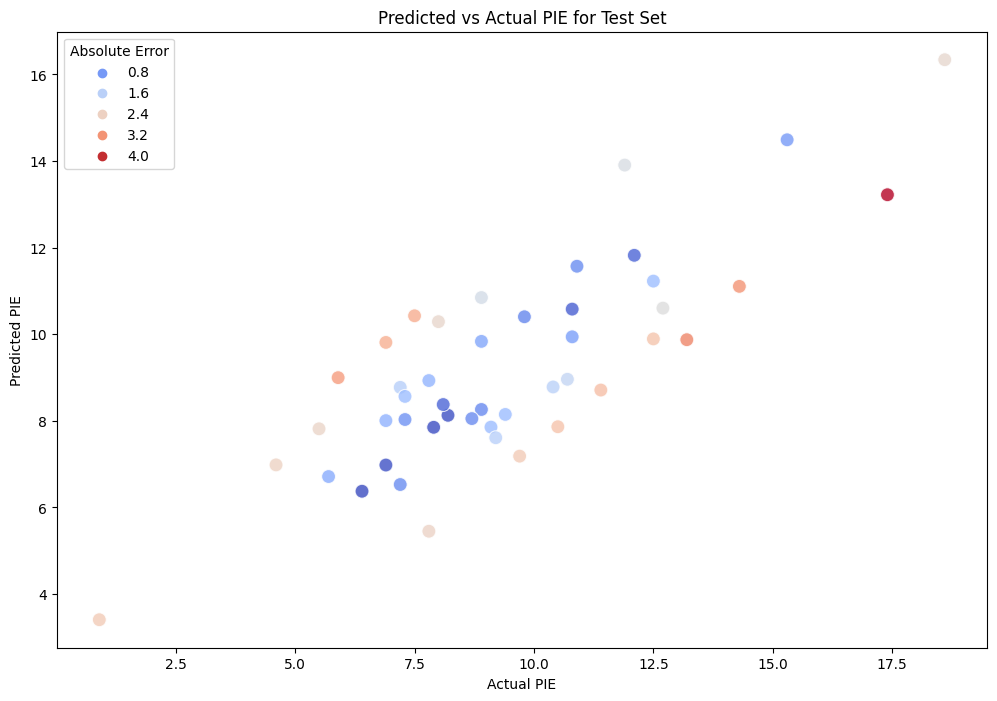

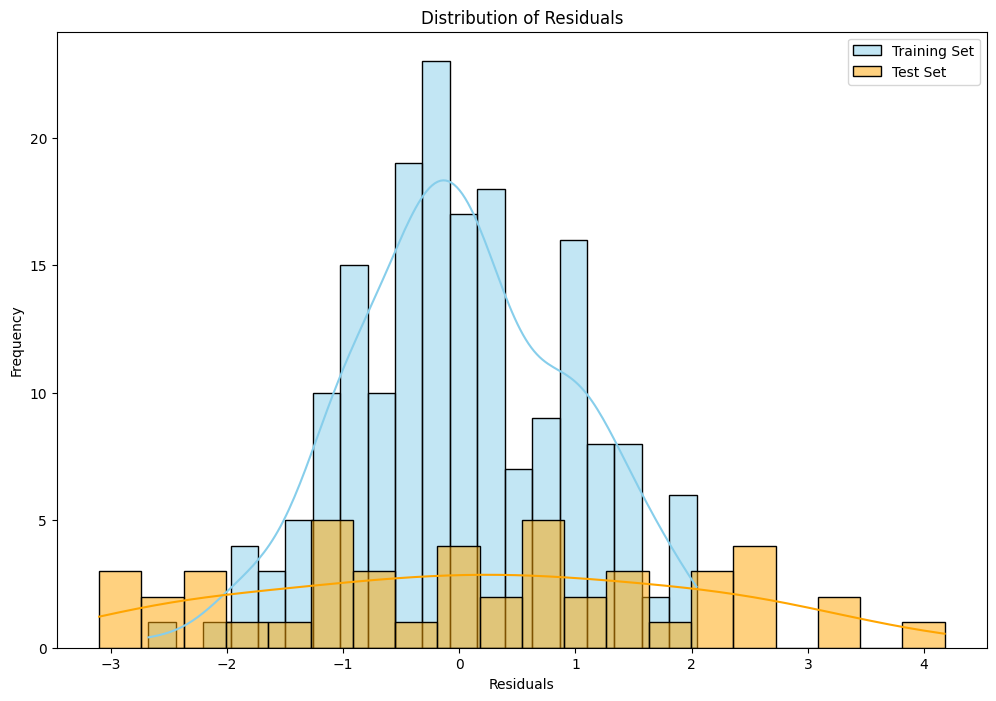

In [ ]:
# Visualize predicted vs actual values on the test set
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_test1, y=y_gb1, hue=np.abs(y_test1 - y_gb1), s=100, alpha=0.8, palette='coolwarm')
plt.xlabel('Actual PIE')
plt.ylabel('Predicted PIE')
plt.title('Predicted vs Actual PIE for Test Set')
plt.legend(loc='upper left', title='Absolute Error')
plt.show()

# Calculate and visualize the residuals
residuals_train1 = y_train1 - y_train_pred1
residuals_test1 = y_test1 - y_gb1

plt.figure(figsize=(12, 8))
sns.histplot(data=residuals_train1, bins=20, kde=True, color='skyblue', label='Training Set')
sns.histplot(data=residuals_test1, bins=20, kde=True, color='orange', label='Test Set')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.legend()
plt.show()

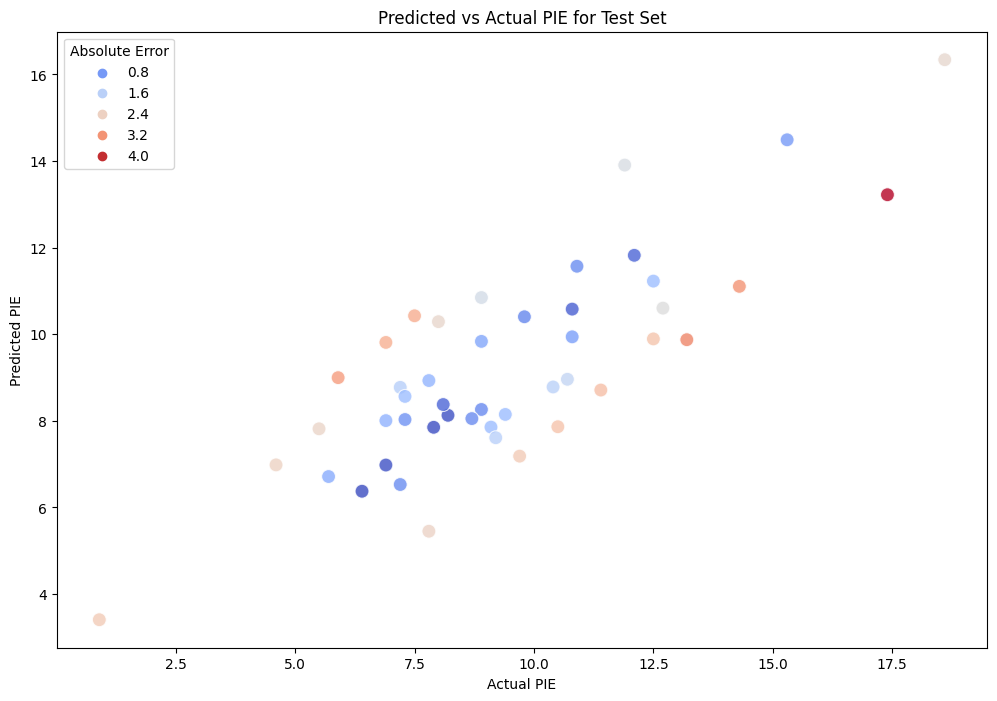

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_test1, y=y_gb1, hue=np.abs(y_test1 - y_gb1), s=100, alpha=0.8, palette='coolwarm')
plt.xlabel('Actual PIE')
plt.ylabel('Predicted PIE')
plt.title('Predicted vs Actual PIE for Test Set')
plt.legend(loc='upper left', title='Absolute Error')
plt.show()

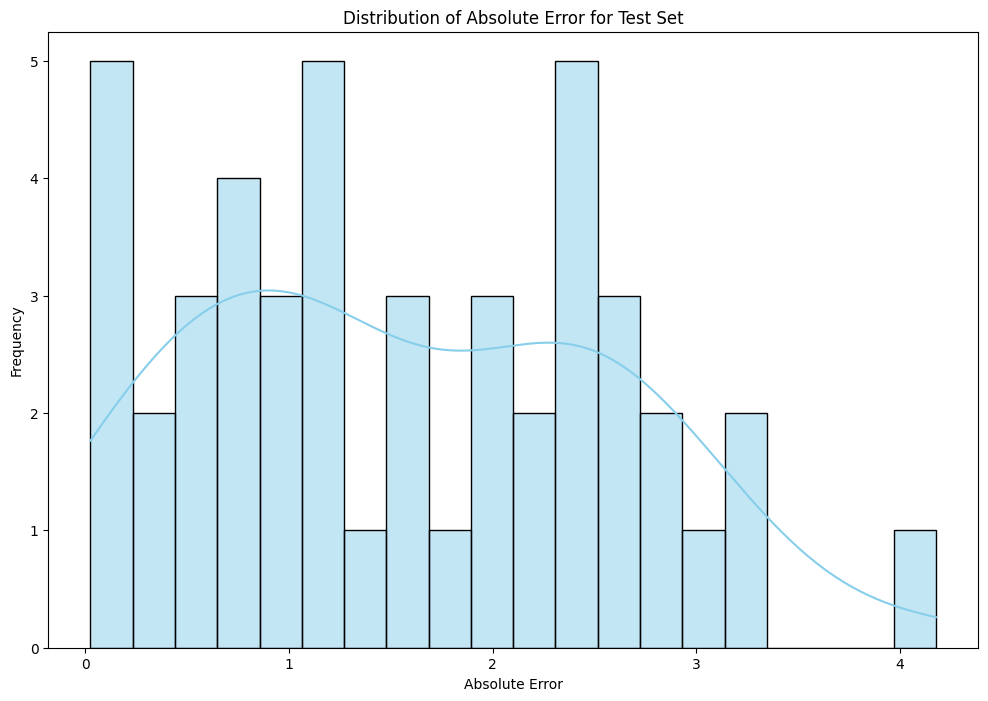

In [ ]:
abs_error = np.abs(y_test1 - y_gb1)
plt.figure(figsize=(12, 8))
sns.histplot(data=abs_error, bins=20, kde=True, color='skyblue')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Distribution of Absolute Error for Test Set')
plt.show()

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


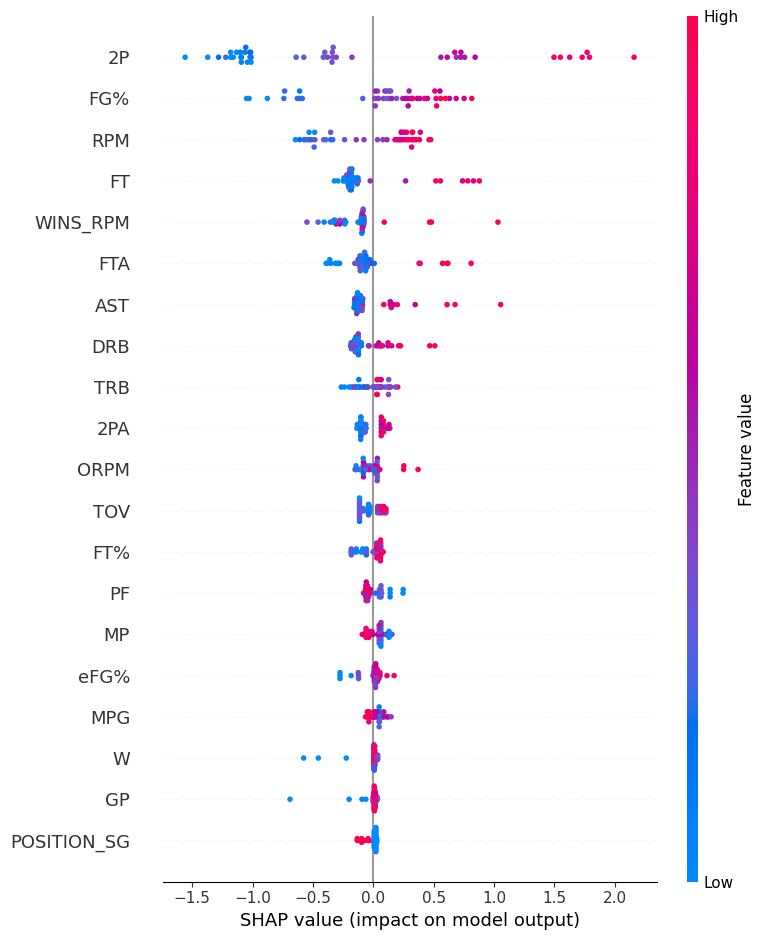

In [ ]:
import shap
shap.initjs()

# SHAP analysis
explainer = shap.Explainer(gb_model1)
shap_values = explainer.shap_values(X_test1)

# Summary plot
shap.summary_plot(shap_values, X_test1, feature_names=X_test1.columns)

# Force plot for a specific instance
instance_index = 0 # Change this to the index of the instance you want to visualize
shap.force_plot(explainer.expected_value, shap_values[instance_index], X_test1.iloc[instance_index])

# Show the plots
plt.show()

In [ ]:
shap.initjs()
instance_index = 1 # Change this to the index of the instance you want to visualize
shap.plots.force(explainer.expected_value, shap_values[instance_index], X_test1.iloc[instance_index])

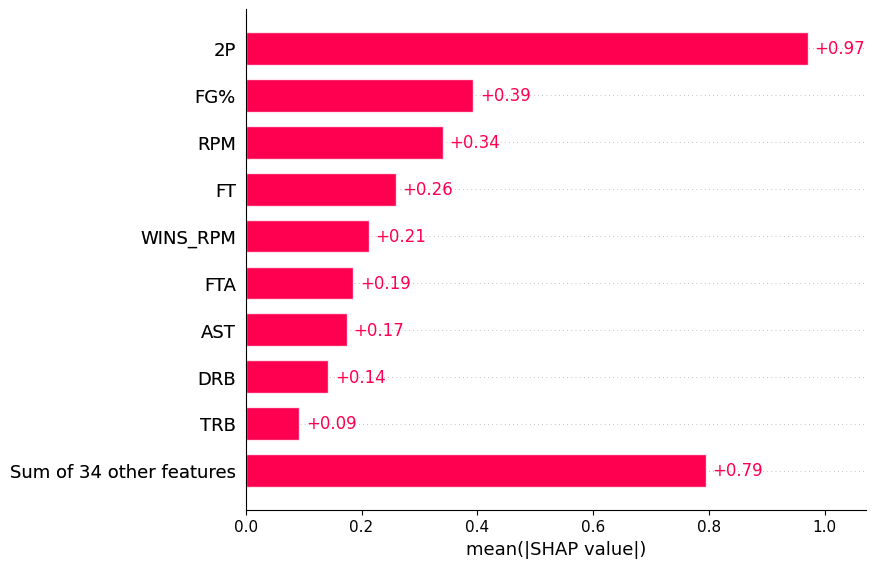

In [ ]:
# Create an explainer object
explainer = shap.Explainer(gb_model1)

# Calculate SHAP values for the test set
shap_values = explainer(X_test1)

# Plot the bar plot of SHAP values
shap.plots.bar(shap_values)